In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import minmax_scale
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# --- Model Parameters ---
# Use a log-normal distribution to model user activity.
# This is a "real-world" assumption: most users trade little (minnows), while a few users trade a lot (whales).
N_USERS = 1000
AVG_TRADES_PER_MONTH = 2.0  # Log-normal mu (controls the "average" user)
STD_TRADES_PER_MONTH = 1.5  # Log-normal sigma (controls the "spread" or whale-effect)
AVG_TRADE_SIZE_USD = 6.0    # Log-normal mu (around $400)
STD_TRADE_SIZE_USD = 2.0    # Log-normal sigma (creates high-value traders)

In [3]:
# --- Define Fee Tiers (Kraken-like Simple Model) ---
# Define tiers based on 30-day (monthly) volume.
def get_fee_rate(monthly_volume):
    """
    Calculates the fee rate based on trading volume.
    """
    if monthly_volume < 50000:
        return 0.0020  # 0.20%
    elif monthly_volume < 1000000:
        return 0.0015  # 0.15%
    else:
        return 0.0010  # 0.10%

In [4]:
# --- Simulate User Base To Populate Data ---
users = pd.DataFrame(index=range(N_USERS))
users['trades_per_month'] = np.random.lognormal(mean=AVG_TRADES_PER_MONTH, sigma=STD_TRADES_PER_MONTH, size=N_USERS).astype(int) + 1  # +1 ensures every user makes at least 1 trade
users['avg_trade_size'] = np.random.lognormal(mean=AVG_TRADE_SIZE_USD, sigma=STD_TRADE_SIZE_USD, size=N_USERS)

In [5]:
# --- Compute Volume and Revenue ---
# Calculate total volume for the month for each user
# Add some randomness to the avg_trade_size for each trade
total_volume = []
for i in range(N_USERS):
    num_trades = users.at[i, 'trades_per_month']
    avg_size = users.at[i, 'avg_trade_size']
    trades = np.random.lognormal(mean=np.log(avg_size), sigma=0.5, size=num_trades)
    total_volume.append(trades.sum())
users['monthly_volume'] = total_volume
users['fee_rate'] = users['monthly_volume'].apply(get_fee_rate)
users['revenue_per_user'] = users['monthly_volume'] * users['fee_rate']

In [6]:
# --- Analysis ---
total_revenue = users['revenue_per_user'].sum()
avg_revenue_per_user = users['revenue_per_user'].mean()
median_revenue_per_user = users['revenue_per_user'].median()
print("\n--- Basic Model Results (1 Month) ---")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Average Revenue per User: ${avg_revenue_per_user:,.2f}")
print(f"Median Revenue per User: ${median_revenue_per_user:,.2f}")


--- Basic Model Results (1 Month) ---
Total Revenue: $72,291.91
Average Revenue per User: $72.29
Median Revenue per User: $6.68


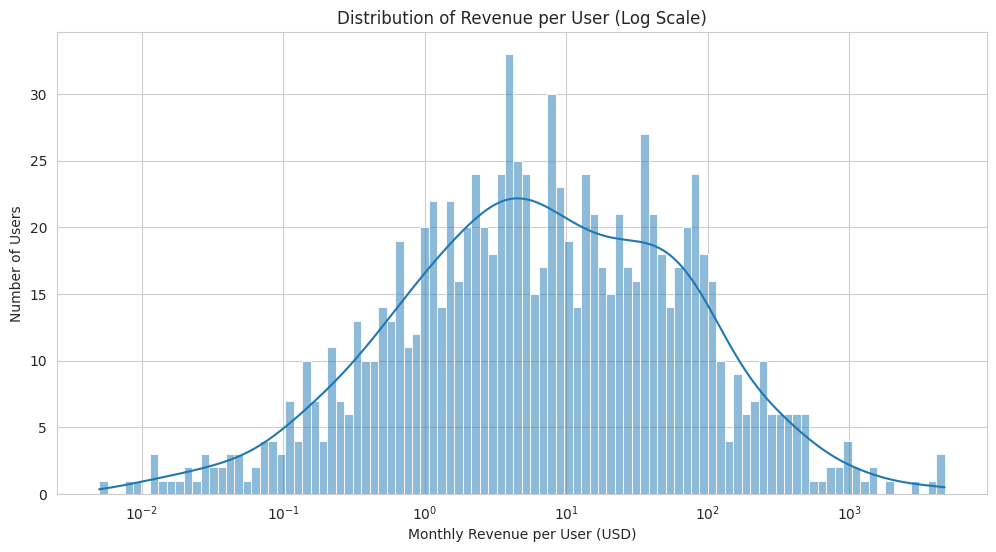

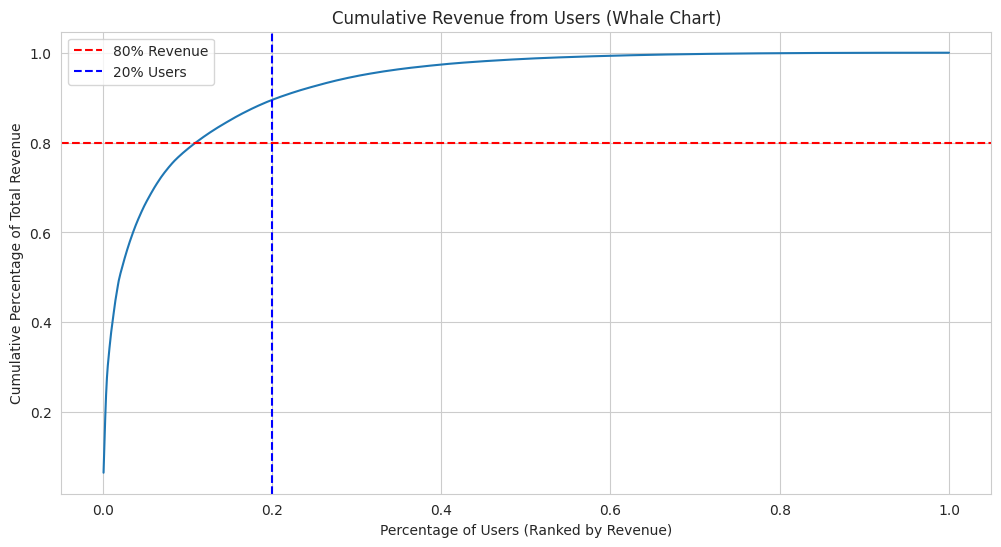


--- Whale Analysis ---
The top 10.9% of users generate 80% of the revenue.


In [7]:
# --- Visualization: Whales' impact ---

# Plot 1: Distribution of Revenue per User
plt.figure(figsize=(12, 6))
sns.histplot(users['revenue_per_user'], bins=100, kde=True, log_scale=True)
plt.title('Distribution of Revenue per User (Log Scale)')
plt.xlabel('Monthly Revenue per User (USD)')
plt.ylabel('Number of Users')
plt.show()

# Plot 2: Pareto Principle (80/20 Rule)
users_sorted = users.sort_values('revenue_per_user', ascending=False)
users_sorted['revenue_cumsum'] = users_sorted['revenue_per_user'].cumsum()
users_sorted['revenue_percent'] = users_sorted['revenue_cumsum'] / total_revenue
users_sorted['user_percent'] = np.arange(1, N_USERS + 1) / N_USERS
plt.figure(figsize=(12, 6))
plt.plot(users_sorted['user_percent'], users_sorted['revenue_percent'])
plt.title('Cumulative Revenue from Users (Whale Chart)')
plt.xlabel('Percentage of Users (Ranked by Revenue)')
plt.ylabel('Cumulative Percentage of Total Revenue')
plt.axhline(0.8, color='red', linestyle='--', label='80% Revenue')
plt.axvline(0.2, color='blue', linestyle='--', label='20% Users')
plt.legend()
plt.show()

# 80% revenue cutoff
whales = users_sorted[users_sorted['revenue_percent'] <= 0.8]
whale_percent = len(whales) / N_USERS
print(f"\n--- Whale Analysis ---")
print(f"The top {whale_percent * 100:.1f}% of users generate 80% of the revenue.")

In [8]:
# --- Refactor into a Full Simulation Function ---

def run_market_simulation(
    weeks=52,
    initial_users=1000,
    weekly_ntu_rate=0.01,         # New Trading Users (NTUs) as % of current users
    weekly_churn_rate=0.005,      # % of users who leave per week
    base_avg_trades=2.0,          # Base log-normal mu
    base_avg_size=6.0,            # Base log-normal mu
    market_volume_modifier=1.0    # Multiplier for trading activity
):
    """
    Runs a 52-week simulation of an exchange's user base and revenue.
    This function simulates the following -
        1. Churn Users
        2. Add New Users (NTUs)
        3. Simulate Weekly Activity for ALL Active Users
        4. Apply market modifier (Bull/Bear Market Conditions based simulations)
        5. Store Results
    """

    users = pd.DataFrame({
        'base_trades_per_week': np.random.lognormal(base_avg_trades, 1.5, initial_users).astype(int) + 1,
        'base_avg_trade_size': np.random.lognormal(base_avg_size, 2.0, initial_users),
        'active': True,
        'join_week': 0
    })

    weekly_results = []
    for week in range(1, weeks + 1):

        active_users = users[users['active']]
        churned_users = active_users.sample(frac=weekly_churn_rate)
        users.loc[churned_users.index, 'active'] = False
        n_active = len(users[users['active']])
        n_new_users = int(n_active * weekly_ntu_rate)

        new_users = pd.DataFrame({
            'base_trades_per_week': np.random.lognormal(base_avg_trades, 1.5, n_new_users).astype(int) + 1,
            'base_avg_trade_size': np.random.lognormal(base_avg_size, 2.0, n_new_users),
            'active': True,
            'join_week': week
        })

        users = pd.concat([users, new_users], ignore_index=True)
        current_active_users = users[users['active']]
        sim_trades_per_week = (current_active_users['base_trades_per_week'] * market_volume_modifier).astype(int)
        sim_avg_trade_size = current_active_users['base_avg_trade_size'] * market_volume_modifier
        weekly_volumes = []
        for i in range(len(current_active_users)):
            num_trades = sim_trades_per_week.iloc[i]
            avg_size = sim_avg_trade_size.iloc[i]
            if num_trades <= 0 or avg_size <= 0:
                weekly_volumes.append(0)
                continue
            trades = np.random.lognormal(mean=np.log(avg_size), sigma=0.5, size=num_trades)
            weekly_volumes.append(trades.sum())

        temp_df = pd.DataFrame({'weekly_volume': weekly_volumes})
        temp_df['estimated_monthly_volume'] = temp_df['weekly_volume'] * 4
        temp_df['fee_rate'] = temp_df['estimated_monthly_volume'].apply(get_fee_rate)
        temp_df['weekly_revenue'] = temp_df['weekly_volume'] * temp_df['fee_rate']
        total_weekly_revenue = temp_df['weekly_revenue'].sum()

        weekly_results.append({
            'week': week,
            'total_users': len(users),
            'active_users': len(current_active_users),
            'ntus': n_new_users,
            'churned': len(churned_users),
            'total_revenue': total_weekly_revenue,
            'avg_revenue_per_user': total_weekly_revenue / len(current_active_users)
        })

    return pd.DataFrame(weekly_results)

In [9]:
# --- Define and Run Scenarios ---

# Scenario 1: Baseline (Stable Market)
baseline_params = {
    'initial_users': 1000,
    'weekly_ntu_rate': 0.01,       # 1% growth
    'weekly_churn_rate': 0.01,     # 1% churn (net flat)
    'market_volume_modifier': 1.0, # Normal volume
    'base_avg_trades': 2.0,
    'base_avg_size': 6.0
}

# Scenario 2: Bull Market
bull_params = {
    'initial_users': 1000,
    'weekly_ntu_rate': 0.05,       # 5% growth (FOMO)
    'weekly_churn_rate': 0.005,    # 0.5% churn (HODL)
    'market_volume_modifier': 2.0, # 2x trading activity
    'base_avg_trades': 2.5,        # Users are more active
    'base_avg_size': 6.5           # Users trade more size
}

# Scenario 3: Bear Market
bear_params = {
    'initial_users': 1000,
    'weekly_ntu_rate': 0.002,      # 0.2% growth (low interest)
    'weekly_churn_rate': 0.03,     # 3% churn (panic/leaving)
    'market_volume_modifier': 0.5, # 0.5x trading activity
    'base_avg_trades': 1.5,        # Users are less active
    'base_avg_size': 5.5           # Users trade smaller size
}

print("Running Market Scenario based simulations")
df_baseline = run_market_simulation(**baseline_params)
df_bull = run_market_simulation(**bull_params)
df_bear = run_market_simulation(**bear_params)

Running Market Scenario based simulations


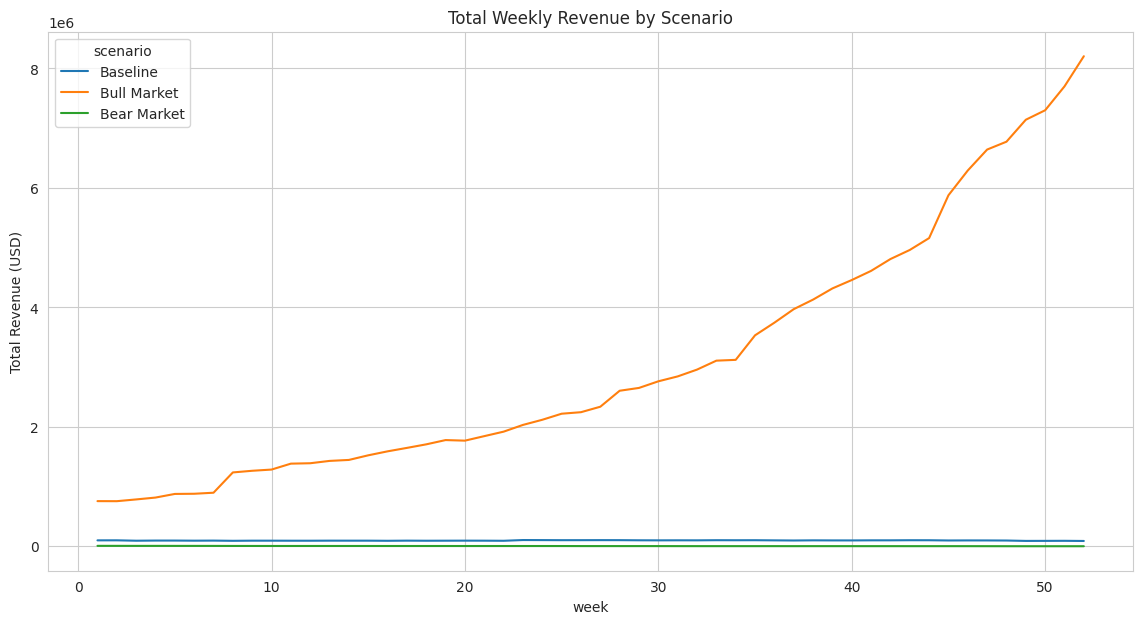

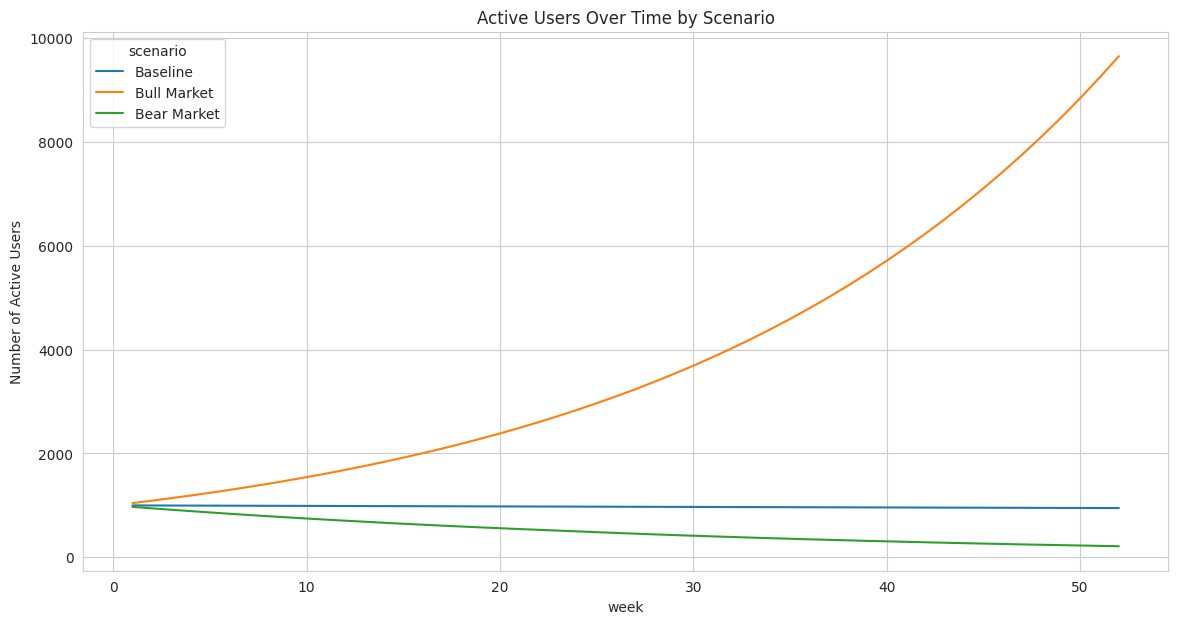


--- Final Yearly Comparison ---
| Scenario    |   Total Revenue |   Ending Active Users |   Avg Revenue per User (Yearly) |
|:------------|----------------:|----------------------:|--------------------------------:|
| Baseline    |    5,088,013.70 |                   949 |                        5,226.41 |
| Bull Market |  159,633,944.96 |                  9654 |                       40,980.08 |
| Bear Market |      243,363.00 |                   213 |                          481.38 |


In [10]:
# --- Comparison and Visualization ---

df_baseline['scenario'] = 'Baseline'
df_bull['scenario'] = 'Bull Market'
df_bear['scenario'] = 'Bear Market'
df_all = pd.concat([df_baseline, df_bull, df_bear])

# Plot 1: Total Revenue Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_all, x='week', y='total_revenue', hue='scenario')
plt.title('Total Weekly Revenue by Scenario')
plt.ylabel('Total Revenue (USD)')
plt.show()

# Plot 2: Active Users Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_all, x='week', y='active_users', hue='scenario')
plt.title('Active Users Over Time by Scenario')
plt.ylabel('Number of Active Users')
plt.show()

# Plot 3: Final Metrics Comparison
final_metrics = {
    'Scenario': ['Baseline', 'Bull Market', 'Bear Market'],
    'Total Revenue': [
        df_baseline['total_revenue'].sum(),
        df_bull['total_revenue'].sum(),
        df_bear['total_revenue'].sum()
    ],
    'Ending Active Users': [
        df_baseline.iloc[-1]['active_users'],
        df_bull.iloc[-1]['active_users'],
        df_bear.iloc[-1]['active_users']
    ],
    'Avg Revenue per User (Yearly)': [
        df_baseline['total_revenue'].sum() / df_baseline['active_users'].mean(),
        df_bull['total_revenue'].sum() / df_bull['active_users'].mean(),
        df_bear['total_revenue'].sum() / df_bear['active_users'].mean()
    ]
}

df_final_comparison = pd.DataFrame(final_metrics)
print("\n--- Final Yearly Comparison ---")
print(df_final_comparison.to_markdown(index=False, floatfmt=",.2f"))

In [11]:
# --- LTV Simulation Parameters ---
N_COHORT = 1000               # Size of the new user cohort
WEEKS_TO_SIMULATE = 52        # 12-month LTV period
WEEKLY_CHURN_RATE = 0.02      # 2% of active users leave each week
MARKET_MODIFIER = 1.0         # Baseline market conditions
AVG_TRADES_PER_WEEK = 1.0     # Log-normal mu (center of the "light" users)
STD_TRADES_PER_WEEK = 1.5
AVG_TRADE_SIZE_USD = 6.0      # Log-normal mu (center of "light" trade size)
STD_TRADE_SIZE_USD = 2.0

In [12]:
# --- Simulate Initial Cohort & Define Segments ---
cohort = pd.DataFrame(index=range(N_COHORT))
cohort['base_trades_per_week'] = np.random.lognormal(AVG_TRADES_PER_WEEK, STD_TRADES_PER_WEEK, N_COHORT).astype(int)
cohort['base_avg_trade_size'] = np.random.lognormal(AVG_TRADE_SIZE_USD, STD_TRADE_SIZE_USD, N_COHORT)
cohort['potential_volume'] = cohort['base_trades_per_week'] * cohort['base_avg_trade_size']
whale_threshold = cohort['potential_volume'].quantile(0.80)
cohort['segment'] = np.where(cohort['potential_volume'] >= whale_threshold, 'Whale (Top 20%)', 'Retail (Bottom 80%)')
cohort['active'] = True  # All users start as active
print(f"Cohort defined. Whale threshold (top 20%) starts at: ${whale_threshold:,.2f} potential weekly volume")

Cohort defined. Whale threshold (top 20%) starts at: $7,388.40 potential weekly volume


In [13]:
# --- Run 52-Week Cohort Simulation (Revenue & Churn) ---
weekly_revenue_data = []
for week in range(1, WEEKS_TO_SIMULATE + 1):
    active_cohort = cohort[cohort['active']]
    if len(active_cohort) == 0:
        break # Everyone has churned
    active_volumes = []
    for i, user in active_cohort.iterrows():
        num_trades = int(user['base_trades_per_week'] * MARKET_MODIFIER)
        avg_size = user['base_avg_trade_size'] * MARKET_MODIFIER
        if num_trades == 0:
            active_volumes.append(0)
            continue
        trades = np.random.lognormal(mean=np.log(avg_size), sigma=0.5, size=num_trades)
        active_volumes.append(trades.sum())

    temp_df = pd.DataFrame({'weekly_volume': active_volumes, 'segment': active_cohort['segment']}, index=active_cohort.index)
    temp_df['estimated_monthly_volume'] = temp_df['weekly_volume'] * 4
    temp_df['fee_rate'] = temp_df['estimated_monthly_volume'].apply(get_fee_rate)
    temp_df['weekly_revenue'] = temp_df['weekly_volume'] * temp_df['fee_rate']
    weekly_revenue_data.append({
        'week': week,
        'active_users': len(active_cohort),
        'revenue_whale': temp_df[temp_df['segment'] == 'Whale (Top 20%)']['weekly_revenue'].sum(),
        'revenue_retail': temp_df[temp_df['segment'] == 'Retail (Bottom 80%)']['weekly_revenue'].sum(),
    })
    churned_users = active_cohort.sample(frac=WEEKLY_CHURN_RATE)
    cohort.loc[churned_users.index, 'active'] = False

print("52-week simulation complete.")

52-week simulation complete.


In [14]:
# --- Calculate LTV ---
df_revenue = pd.DataFrame(weekly_revenue_data)
n_whales = len(cohort[cohort['segment'] == 'Whale (Top 20%)'])
n_retail = len(cohort[cohort['segment'] == 'Retail (Bottom 80%)'])
total_revenue_whale = df_revenue['revenue_whale'].sum()
total_revenue_retail = df_revenue['revenue_retail'].sum()
ltv_whale = total_revenue_whale / n_whales
ltv_retail = total_revenue_retail / n_retail
ltv_blended = (total_revenue_whale + total_revenue_retail) / N_COHORT
print("\n--- 12-Month LTV Results ---")
print(f"Blended LTV (all users): ${ltv_blended:,.2f}")
print(f"Retail LTV (Bottom 80%): ${ltv_retail:,.2f}")
print(f"Whale LTV (Top 20%):   ${ltv_whale:,.2f}")
print(f"LTV Ratio (Whale to Retail): {ltv_whale / ltv_retail:.1f}x")


--- 12-Month LTV Results ---
Blended LTV (all users): $770.10
Retail LTV (Bottom 80%): $77.04
Whale LTV (Top 20%):   $3,542.35
LTV Ratio (Whale to Retail): 46.0x


In [15]:
# --- CAC & Payback Period Analysis ---
# Assume hypothetical CACs based on acquisition channel
# These are *assumptions* for the model
cac_channels = {
    'Organic/Referral': 50,  # Low cost, often retail
    'Paid Search (Retail)': 200, # Expensive, targets retail
    'Affiliate/IB (Whale)': 1500  # Very expensive, but targets whales
}
avg_monthly_rev_retail = ltv_retail / 12
avg_monthly_rev_whale = ltv_whale / 12
payback_retail_months = cac_channels['Paid Search (Retail)'] / avg_monthly_rev_retail
payback_whale_months = cac_channels['Affiliate/IB (Whale)'] / avg_monthly_rev_whale
ltv_cac_retail = ltv_retail / cac_channels['Paid Search (Retail)']
ltv_cac_whale = ltv_whale / cac_channels['Affiliate/IB (Whale)']
print("\n--- LTV/CAC & Payback Analysis ---")
print(f"Retail (LTV: ${ltv_retail:,.2f} | CAC: ${cac_channels['Paid Search (Retail)']})")
print(f"  LTV/CAC Ratio: {ltv_cac_retail:.2f}")
print(f"  Payback Period: {payback_retail_months:.2f} months")
print(f"\nWhale (LTV: ${ltv_whale:,.2f} | CAC: ${cac_channels['Affiliate/IB (Whale)']})")
print(f"  LTV/CAC Ratio: {ltv_cac_whale:.2f}")
print(f"  Payback Period: {payback_whale_months:.2f} months")


--- LTV/CAC & Payback Analysis ---
Retail (LTV: $77.04 | CAC: $200)
  LTV/CAC Ratio: 0.39
  Payback Period: 31.15 months

Whale (LTV: $3,542.35 | CAC: $1500)
  LTV/CAC Ratio: 2.36
  Payback Period: 5.08 months


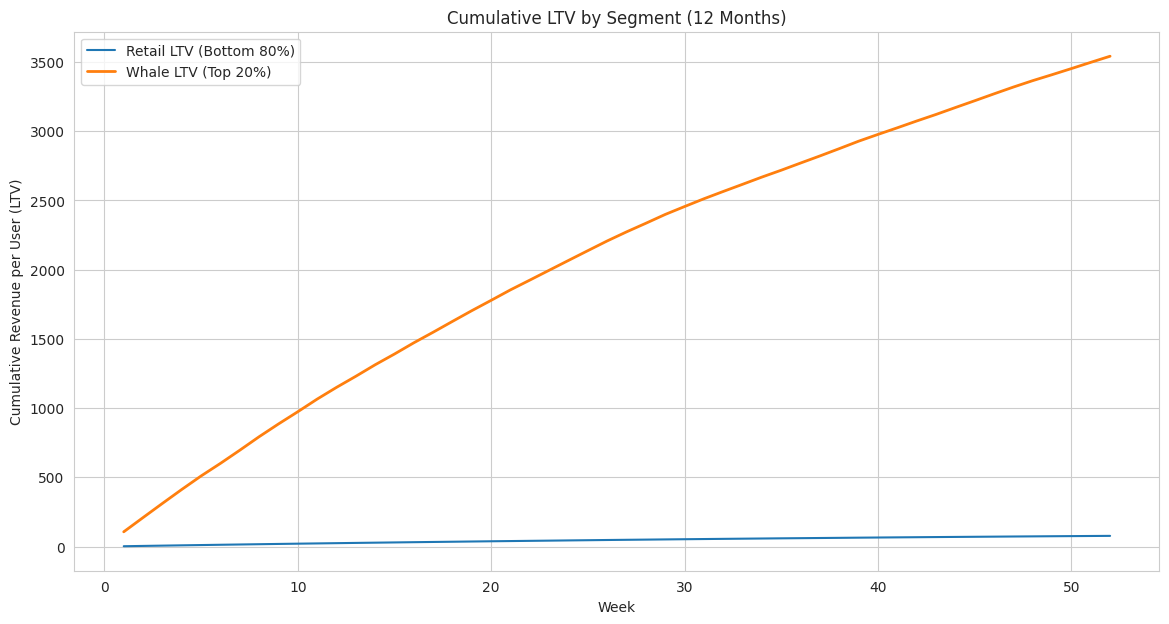

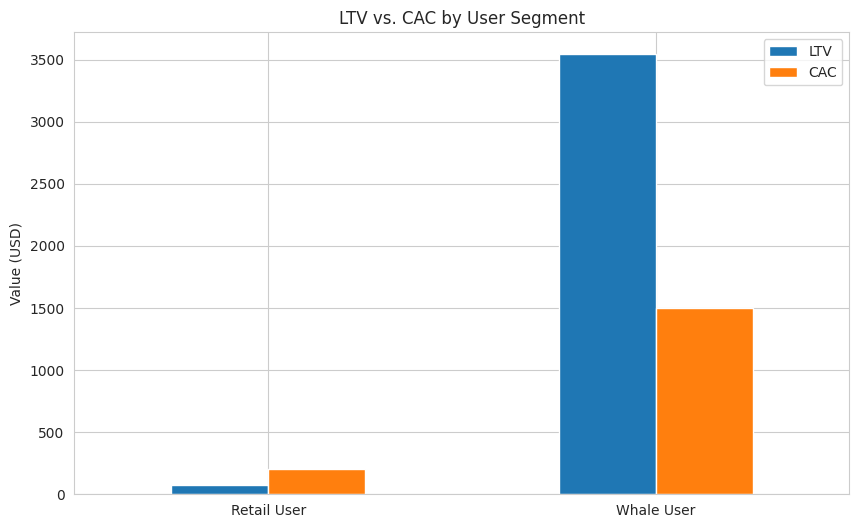

In [16]:
# --- Visualization ---
df_revenue['cum_revenue_whale'] = df_revenue['revenue_whale'].cumsum() / n_whales
df_revenue['cum_revenue_retail'] = df_revenue['revenue_retail'].cumsum() / n_retail

# Plot 1: Cumulative LTV over 52 Weeks
plt.figure(figsize=(14, 7))
plt.plot(df_revenue['week'], df_revenue['cum_revenue_retail'], label='Retail LTV (Bottom 80%)')
plt.plot(df_revenue['week'], df_revenue['cum_revenue_whale'], label='Whale LTV (Top 20%)', linewidth=2)
plt.title('Cumulative LTV by Segment (12 Months)')
plt.xlabel('Week')
plt.ylabel('Cumulative Revenue per User (LTV)')
plt.legend()
plt.show()

# Plot 2: LTV vs. CAC Bar Chart
ltv_data = [ltv_retail, ltv_whale]
cac_data = [cac_channels['Paid Search (Retail)'], cac_channels['Affiliate/IB (Whale)']]
labels = ['Retail User', 'Whale User']
df_plot = pd.DataFrame({'LTV': ltv_data, 'CAC': cac_data}, index=labels)
df_plot.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('LTV vs. CAC by User Segment')
plt.ylabel('Value (USD)')
plt.show()

In [17]:
# --- Create the "Behavioral Physics" Feature Vector ---
# In a real project, these would be complex, derived features from current features.

# Simulate "Timing Asymmetry" (e.g., -1 = counter-cyclical, +1 = pro-cyclical)
# Whales might be more counter-cyclical.
mean = np.where(cohort['segment'] == 'Whale (Top 20%)', -0.2, 0.1)
cohort['timing_asymmetry'] = np.random.normal(loc=mean, scale=0.3, size=N_COHORT)

# Simulate "Trade Entropy" (e.g., 0 = very predictable, 1 = very random)
# Whales might show *lower* entropy (more planned)
mean = np.where(cohort['segment'] == 'Whale (Top 20%)', 0.3, 0.7)
cohort['trade_entropy'] = np.random.normal(loc=mean, scale=0.1, size=N_COHORT)

# Simulate "Liquidity Sensitivity" (e.g., 0 = only trades deep books, 1 = exploits thin books)
mean = np.where(cohort['segment'] == 'Whale (Top 20%)', 0.6, 0.2)
cohort['liquidity_sensitivity'] = np.random.normal(loc=mean, scale=0.1, size=N_COHORT)

# --- Save the Feature Vector ---
# This file is the input for our "Whale Temperature Map"
output_filename = 'proto_whale_feature_vector.csv'
cohort.to_csv(output_filename)

print(f"Enriched behavioral feature vector saved to: {output_filename}")
print("\nFeature Vector Head:")
print(cohort.head())

Enriched behavioral feature vector saved to: proto_whale_feature_vector.csv

Feature Vector Head:
   base_trades_per_week  base_avg_trade_size  potential_volume  \
0                    63          7038.138273     443402.711188   
1                     1          2766.689215       2766.689215   
2                     3          1623.964648       4871.893944   
3                     3          4472.587295      13417.761884   
4                     1          1449.408279       1449.408279   

               segment  active  timing_asymmetry  trade_entropy  \
0      Whale (Top 20%)    True          0.020264       0.272162   
1  Retail (Bottom 80%)   False          0.185649       0.699059   
2  Retail (Bottom 80%)    True          0.393763       0.691054   
3      Whale (Top 20%)   False         -0.398479       0.345118   
4  Retail (Bottom 80%)    True         -0.252737       0.638883   

   liquidity_sensitivity  
0               0.384695  
1               0.328208  
2               0.189

Simulating 52,000 user-weeks of data...
Calculating whale scores and status...


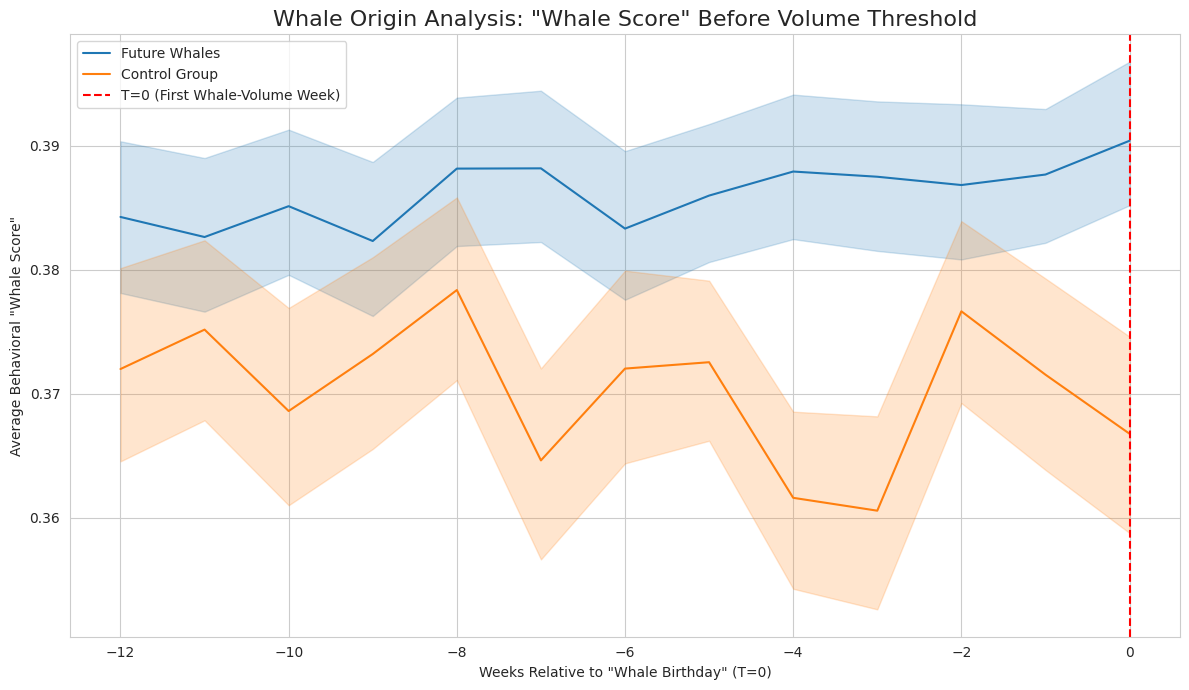

In [23]:
# --- Simulation Parameters ---
N_USERS = 1000
N_WEEKS = 52
WHALE_PERCENT = 0.01  # 1% of users will become whales
N_WHALES = int(N_USERS * WHALE_PERCENT)
N_RETAIL = N_USERS - N_WHALES

# "Behavioral Genome" means (from above cells)
RETAIL_MEANS = {'timing': 0.1, 'entropy': 0.7, 'liquidity': 0.2}
WHALE_MEANS = {'timing': -0.2, 'entropy': 0.3, 'liquidity': 0.6}
BEHAVIOR_STD = 0.1 # Std dev for behavioral noise

# --- Create Panel Data Skeleton ---
# Create a user lookup table
users = pd.DataFrame({
    'user_id': range(N_USERS),
    'is_future_whale': [True] * N_WHALES + [False] * N_RETAIL,
    'whale_birthday': [np.nan] * N_USERS
})
users = users.sample(frac=1).reset_index(drop=True) # Shuffle users

# Assign a "whale birthday" (between week 26 and 52) to future whales
whale_birthdays = np.random.randint(26, N_WEEKS, N_WHALES)
users.loc[users['is_future_whale'], 'whale_birthday'] = whale_birthdays

# Create the full panel DataFrame (UserID x Week)
panel_df = pd.DataFrame(index=pd.MultiIndex.from_product(
    [range(N_USERS), range(N_WEEKS)],
    names=['user_id', 'week']
)).reset_index()

# Join user info into the panel
panel_df = panel_df.merge(users, on='user_id')

# --- Simulate Behavioral & Volume Trajectories (The Hypothesis) ---
print("Simulating 52,000 user-weeks of data...")
timing_list, entropy_list, liquidity_list, volume_list = [], [], [], []

for row in panel_df.itertuples():
    if not row.is_future_whale:
        # --- RETAIL (CONTROL) TRAJECTORY ---
        # Behavior is just noise around the retail mean
        timing = np.random.normal(RETAIL_MEANS['timing'], BEHAVIOR_STD)
        entropy = np.random.normal(RETAIL_MEANS['entropy'], BEHAVIOR_STD)
        liquidity = np.random.normal(RETAIL_MEANS['liquidity'], BEHAVIOR_STD)
        volume = np.random.lognormal(mean=6.0, sigma=2.0) # Standard low volume
    else:
        # --- FUTURE WHALE TRAJECTORY ---
        birthday = row.whale_birthday

        if row.week < birthday:
            # --- "Proto-Whale" Phase (Before Birthday) ---
            # Calculate "progress" to becoming a whale (0.0 to 1.0)
            drift_start = max(0, birthday - 26)
            progress = max(0, (row.week - drift_start) / (birthday - drift_start + 1e-6))

            # Linearly interpolate behavior from Retail -> Whale
            timing = (1 - progress) * RETAIL_MEANS['timing'] + progress * WHALE_MEANS['timing']
            entropy = (1 - progress) * RETAIL_MEANS['entropy'] + progress * WHALE_MEANS['entropy']
            liquidity = (1 - progress) * RETAIL_MEANS['liquidity'] + progress * WHALE_MEANS['liquidity']

            # Add some noise
            timing = np.random.normal(timing, BEHAVIOR_STD)
            entropy = np.random.normal(entropy, BEHAVIOR_STD)
            liquidity = np.random.normal(liquidity, BEHAVIOR_STD)
            volume = np.random.lognormal(mean=6.0, sigma=2.0) # Still has retail volume
        else:
            # --- "Whale" Phase (At/After Birthday) ---
            # Behavior is locked to whale mean (with noise)
            timing = np.random.normal(WHALE_MEANS['timing'], BEHAVIOR_STD)
            entropy = np.random.normal(WHALE_MEANS['entropy'], BEHAVIOR_STD)
            liquidity = np.random.normal(WHALE_MEANS['liquidity'], BEHAVIOR_STD)
            volume = np.random.lognormal(mean=11.0, sigma=2.5) # Massive whale volume

    timing_list.append(timing)
    entropy_list.append(entropy)
    liquidity_list.append(liquidity)
    volume_list.append(volume)

panel_df['timing_asymmetry'] = timing_list
panel_df['trade_entropy'] = entropy_list
panel_df['liquidity_sensitivity'] = liquidity_list
panel_df['volume'] = volume_list

# --- Define "Whale Score" & "Whale Status" ---
print("Calculating whale scores and status...")
# Normalize features 0-1 (higher is "more whale-like")
panel_df['timing_norm'] = minmax_scale(panel_df['timing_asymmetry'] * -1) # Invert so counter-cyclical is high
panel_df['entropy_norm'] = minmax_scale(panel_df['trade_entropy'] * -1)   # Invert so planned is high
panel_df['liquidity_norm'] = minmax_scale(panel_df['liquidity_sensitivity'])

# Define whale_score_t (simple average of normalized features)
panel_df['whale_score'] = (panel_df['timing_norm'] + panel_df['entropy_norm'] + panel_df['liquidity_norm']) / 3

# Define "is_volume_whale" for this week (e.g., top 5% of weekly volume)
volume_threshold = panel_df['volume'].quantile(0.95)
panel_df['is_volume_whale'] = panel_df['volume'] >= volume_threshold

analysis_window = 12 # Look back 12 weeks - this could be months/years for more insight on real-world data
trajectory_data = []

# Get all users who *ever* become a volume whale
whales_who_were_born = panel_df[panel_df['is_volume_whale'] == True]['user_id'].unique()
future_whales_df = panel_df[panel_df['user_id'].isin(whales_who_were_born)]

# Get the control group
control_df = panel_df[~panel_df['user_id'].isin(whales_who_were_born)]

# "Future Whale" Trajectory
for user_id, group in future_whales_df.groupby('user_id'):
    # Find the *first* week they became a volume whale
    try:
        birthday = group[group['is_volume_whale'] == True]['week'].min()
    except ValueError:
        continue # This user didn't actually cross the threshold

    for t_minus in range(analysis_window, -1, -1):
        week_to_check = birthday - t_minus
        if week_to_check < 0:
            continue

        score = group[group['week'] == week_to_check]['whale_score'].values[0]
        trajectory_data.append({
            'group': 'Future Whales',
            't_minus': -t_minus, # T-12, T-11, ... T-0
            'whale_score': score
        })

# "Control Group" Trajectory
# Just sample 12-week windows from non-whales to compare
for user_id, group in control_df.groupby('user_id'):
    anchor_week = np.random.randint(analysis_window, N_WEEKS)
    for t_minus in range(analysis_window, -1, -1):
        week_to_check = anchor_week - t_minus
        score = group[group['week'] == week_to_check]['whale_score'].values[0]
        trajectory_data.append({
            'group': 'Control Group',
            't_minus': -t_minus,
            'whale_score': score
        })
trajectory_df = pd.DataFrame(trajectory_data)

# --- Plot the Trajectory ---
plt.figure(figsize=(12, 7))
sns.lineplot(data=trajectory_df, x='t_minus', y='whale_score', hue='group', errorbar='ci')
plt.title('Whale Origin Analysis: "Whale Score" Before Volume Threshold', fontsize=16)
plt.xlabel('Weeks Relative to "Whale Birthday" (T=0)')
plt.ylabel('Average Behavioral "Whale Score"')
plt.axvline(x=0, color='red', linestyle='--', label='T=0 (First Whale-Volume Week)')
plt.legend()
plt.tight_layout()
plt.show()

Generating 3D behavioral cluster map...


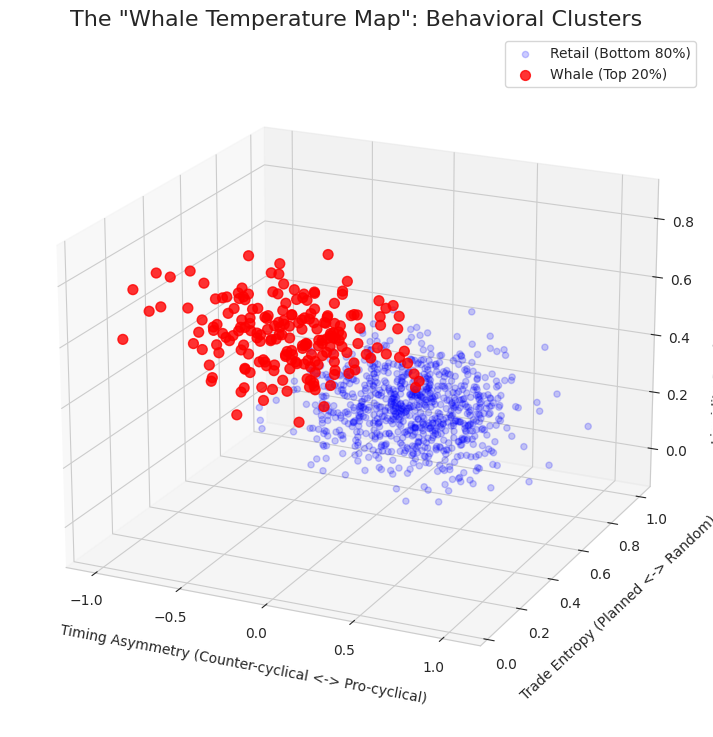

In [18]:
# --- Load the Behavioral Feature Vector ---
try:
    data = pd.read_csv('proto_whale_feature_vector.csv')
except FileNotFoundError:
    print("Error: 'proto_whale_feature_vector.csv' not found.")
    print("Please run the previous 'ds_python_interpreter' step to generate this file.")
    exit()

# --- Prepare Data for Plotting ---
whales = data[data['segment'] == 'Whale (Top 20%)']
retail = data[data['segment'] == 'Retail (Bottom 80%)']

# --- Create the 3D "Whale Temperature Map" ---
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the Retail users
ax.scatter(retail['timing_asymmetry'],
           retail['trade_entropy'],
           retail['liquidity_sensitivity'],
           c='blue',
           label='Retail (Bottom 80%)',
           alpha=0.2)

# Plot the Whales
ax.scatter(whales['timing_asymmetry'],
           whales['trade_entropy'],
           whales['liquidity_sensitivity'],
           c='red',
           label='Whale (Top 20%)',
           s=50,  # Make whales slightly larger
           alpha=0.8)

# --- Customize the 3D Plot ---
ax.set_title('The "Whale Temperature Map": Behavioral Clusters', fontsize=16)
ax.set_xlabel('Timing Asymmetry (Counter-cyclical <-> Pro-cyclical)', labelpad=10)
ax.set_ylabel('Trade Entropy (Planned <-> Random)', labelpad=10)
ax.set_zlabel('Liquidity Sensitivity (Exploitative)', labelpad=10)
ax.legend()
ax.view_init(elev=20., azim=-65) # Set a good viewing angle

print("Generating 3D behavioral cluster map...")
plt.show()

Generating 2D projection plots...


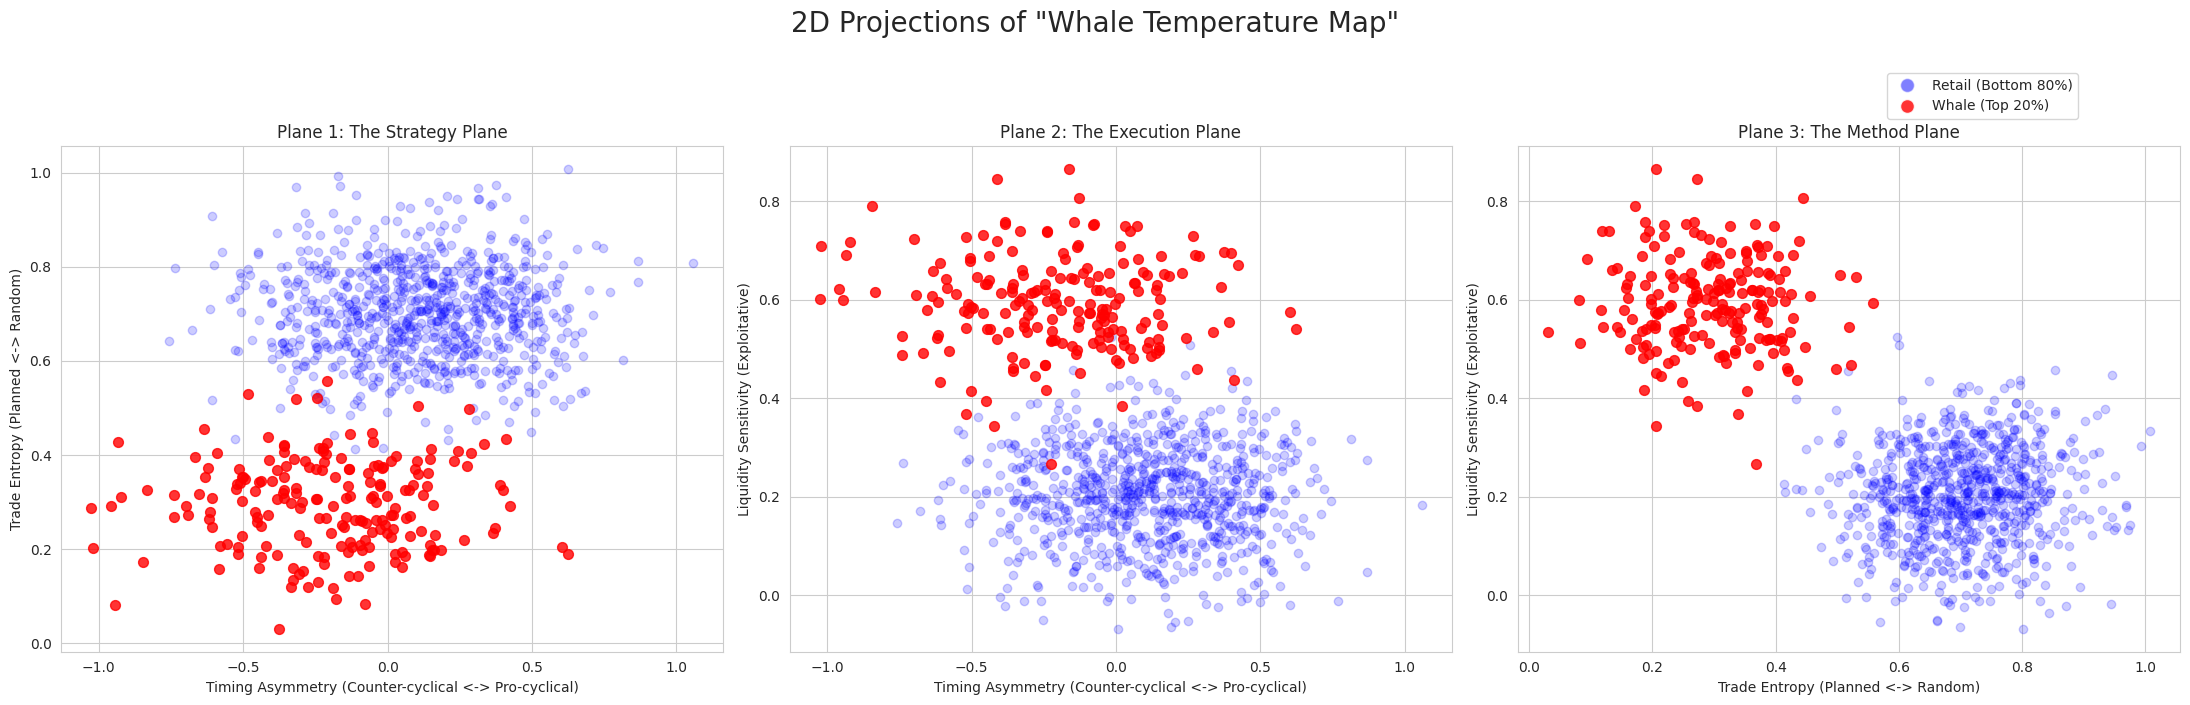

Plots generated. Close the plot window to continue.


In [19]:
# --- Create the 2D Projection Plots (1x3 grid) ---
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7))

# Plot 1 (XY Plane): "The Strategy Plane"
ax1.scatter(retail['timing_asymmetry'], retail['trade_entropy'], c='blue', label='Retail', alpha=0.2)
ax1.scatter(whales['timing_asymmetry'], whales['trade_entropy'], c='red', label='Whale', s=50, alpha=0.8)
ax1.set_xlabel('Timing Asymmetry (Counter-cyclical <-> Pro-cyclical)')
ax1.set_ylabel('Trade Entropy (Planned <-> Random)')
ax1.set_title('Plane 1: The Strategy Plane')

# Plot 2 (XZ Plane): "The Execution Plane"
ax2.scatter(retail['timing_asymmetry'], retail['liquidity_sensitivity'], c='blue', label='Retail', alpha=0.2)
ax2.scatter(whales['timing_asymmetry'], whales['liquidity_sensitivity'], c='red', label='Whale', s=50, alpha=0.8)
ax2.set_xlabel('Timing Asymmetry (Counter-cyclical <-> Pro-cyclical)')
ax2.set_ylabel('Liquidity Sensitivity (Exploitative)')
ax2.set_title('Plane 2: The Execution Plane')

# Plot 3 (YZ Plane): "The Method Plane"
ax3.scatter(retail['trade_entropy'], retail['liquidity_sensitivity'], c='blue', label='Retail', alpha=0.2)
ax3.scatter(whales['trade_entropy'], whales['liquidity_sensitivity'], c='red', label='Whale', s=50, alpha=0.8)
ax3.set_xlabel('Trade Entropy (Planned <-> Random)')
ax3.set_ylabel('Liquidity Sensitivity (Exploitative)')
ax3.set_title('Plane 3: The Method Plane')

# --- Customize and Show ---
fig.suptitle('2D Projections of "Whale Temperature Map"', fontsize=20, y=1.03)
# Manually create handles for a single figure legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label='Retail (Bottom 80%)',
                          markerfacecolor='blue', markersize=10, alpha=0.5),
           plt.Line2D([0], [0], marker='o', color='w', label='Whale (Top 20%)',
                          markerfacecolor='red', markersize=10, alpha=0.8)]
fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.95, 0.95))

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
print("Generating 2D projection plots...")
plt.show()
print("Plots generated. Close the plot window to continue.")